In [4]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import combinations

from qiskit import BasicAer, Aer, transpile, assemble
# from qiskit.aqua import QuantumInstance, aqua_globals
# from qiskit.aqua.algorithms import VQC
from qiskit.algorithms.optimizers import SPSA, COBYLA
from qiskit.circuit.library import TwoLocal, ZZFeatureMap
from qiskit.circuit import QuantumCircuit, Gate, Parameter
# from qiskit.aqua.utils import split_dataset_to_data_and_labels, map_label_to_class_name


seed = 10599
# aqua_globals.random_seed = seed

## Hybrid Quantum-Classical Machine Learning 

Quantum embeddings for machine learning 

arXiv:2001.03622

### Binary Classification

- Binary classification is a process to predict (or assign) a data point to one of two classes (categories). 

- We can define a function (known as the objective function) that computes our "error" (known as cost) once we assign a data point to a class. 

- Our goal is to find the parameters (or weights) of the objective function that will minimize our cost, i.e minimize our error of assignment.

<!-- <img src="QMetric_Simple_Circ_Idea.png" width="1500" height="1000" align="center"/> -->

<img src="General_QML.png" width="1500" height="1000" align="center"/>

### Quantum Feature Map

- A quantum feature map will embed the input features (data) into **Hilbert Space**. 
    - Hilbert Space, is the space for quantum bits, which for one qubit can be represented as a sphere. 
    - The dimensionality of this space increases as $2^{n}$ where n is the number of qubits. 

- Common trick in ML is to map your data to high dimensional space (the kernel trick), we do the same but with an exponentially larger dimensional space

A **quantum** feature map is a function that takes in classical data and returns a quantum state. We transform $x\implies |\phi(x)\rangle$ using a sequence of unitary rotation gates $U_{\phi}(x)$, which is a quantum circuit where the angles of rotation (of our state) depend on the input data.

In other words, the quantum feature map **encodes** our classical data into **Hilbert Space** (where the qubits live) and maps each input data to a **quantum state**

We use the large dimensionality of this quantum circuit to embed our data points into a Hilbert Space where we can **efficiently** compute metrics like "distance"

### Variational Quantum Classifiers

- Variational quantum classifiers are quantum circuits with rotation angles (parameters or weights) that embed input data in Hilbert space and perform quantum measurements to discriminate between classes. 

- This is done by:
    - Applying a quantum feature map (a circuit where the rotation angles depend on the input data) .
    - Followed by a variational circuit (where the rotation angles are varied by an optimizer when computing the objective or cost function)

<!-- <img src="variational_circuit.png" width="1500" height="1000" align="center"/> -->

### Cost Function (Variational Circuit)

The variational circuit has it's angles of rotation varied by an optimizer when computing the quantum classifier's cost function. 
This can be represented by the transformation: $U(\theta)|\psi \rangle \equiv |\psi(\theta)\rangle$, where $|\psi \rangle$ is the starting state. 

- We encode two datapoints into quantum states.
- Apply transformations using gates with **parameters** ($\theta$)

- Compute the "distance" between the two datapoints for the given values of the **parameters**
    - The "distance" between points from the **same** class (category) is **minimized**
    - The "distance" between points from **different** classes (categories) is **maximized**
    - These two "distances" give us the cost that we are trying to optimize

How do we optimize?
- Randomly initialize all $\theta$. 
    - We arbitrarily select a state $|\psi\rangle$ as an initial guess that approximates $|\psi_{min}\rangle$, the state where our **cost** is minimized. 

- Compute cost using distances between datapoints
- Iteratively update all $\theta$, which gives a new state $|\psi\rangle$ and brings us closer to $|\psi_{min}\rangle$ 

<img src="General_QML_Training.png" width="1500" height="1000" align="center"/>

### Example
We have some 1D data here with two possible classes, **A** and **B**. 
<img src="1d_data_long.png" width="1300" height="800" align="center"/>

/Users/ag30293/anaconda3/envs/quantum/lib/python3.7/site-packages/ipykernel_launcher.py:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  app.launch_new_instance()


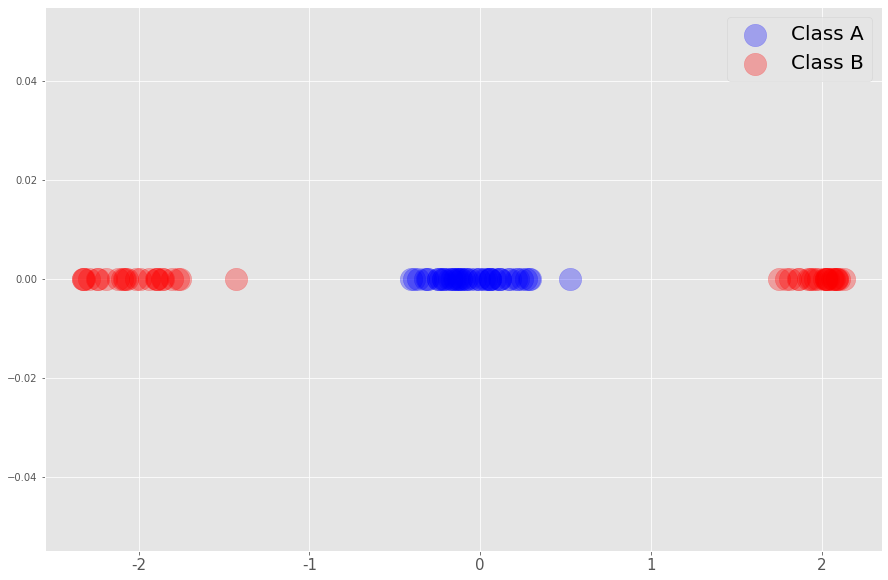

In [2]:
plt.style.use('ggplot')

data_0 = np.random.normal(0, 0.25, size=48)
data_1 = np.concatenate((np.random.normal(-2, 0.25, size=24), np.random.normal(2, 0.1, size=24)))

x_train_0 = data_0[:32]
x_train_1 = data_1[:32]

x_test_0 = data_0[32:]
x_test_1 = data_1[32:]

fig, ax = plt.subplots(figsize=(15, 10))

ax.scatter(data_0, np.zeros(48), c='b', label='Class A', alpha=0.3, s=500)
ax.scatter(data_1, np.zeros(48), c='r', label='Class B', alpha=0.3, s=500)
ax.set_xticklabels(np.arange(-3, 3, 1), fontsize=15)
_ = ax.legend(fontsize=20)

plt.savefig("1d_data_long.png")

The two components used:

- A quantum feature map with an $R_{X}(x_{i})$ Gate, that will take our input data point and map them to Hilbert Space. 

- The variational circuit will contain a $R_{Y}(\theta)$ Gate, where our **parameters** will be the angles for the rotation gates. 


These two circuits together will be a "layer" and the final circuit will consist of 4 layers, with each variational circuit (in a given layer) adding another parameter.

<img src="full_circ.png" width="1600" height="1000" align="center"/>

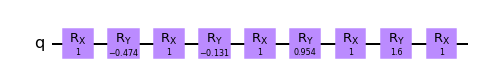

In [3]:

circ = QuantumCircuit(1)
x_1 = 1
circ.rx(x_1, qubit=0) #x_1
for i in range(4):
    circ.ry(np.random.uniform(-2, 2), qubit=0) #theta_i
    circ.rx(x_1, qubit=0) # x_1

circ.draw('mpl')

- Our goal is to learn the **parameters**, $\theta_{i}$ that can maximize the distance between different classes (and minimize for the same class) in Hilbert Space.

- We will use two qubits one with data from class A and the other from class B, these are passed through the circuit and the overlap (distance) between the states is computed using a swap test. 

- This "overlap" measures the distance between two states. 

<!-- ### Final Circuit

<img src="full_circ.png" width="1500" height="1000" align="center"/> -->

In [4]:
def embedding_circuit(x1, x2, params):

    circ = QuantumCircuit(3, 1)
    circ.rx(x1, qubit=0)
    circ.rx(x2, qubit=1)

    for theta in params:
        circ.ry(theta, qubit=0)
        circ.rx(x1, qubit=0)

        circ.ry(theta, qubit=1)
        circ.rx(x2, qubit=1)
    
    circ.barrier()
    circ.h(2)
    circ.cswap(2, 1, 0)
    circ.h(2)
    
    circ.measure(2, 0)

    return circ 


In [5]:
def get_overlaps(sample0, sample1, params):
    
    overlap_measures = []
    backend = Aer.get_backend("qasm_simulator")
    num_shots = 10000

    for x_1, x_2 in zip(sample0, sample1):
        qc_11 = embedding_circuit(x_1, x_1, params)
        qc_22 = embedding_circuit(x_2, x_2, params)
        qc_12 = embedding_circuit(x_1, x_2, params)
        
        results = []

        for qc in [qc_11, qc_22, qc_12]:
            t_qc = transpile(qc, backend)
            result = backend.run(t_qc, shots=num_shots).result().get_counts(qc)
            results.append(sum([int(count)/num_shots if state == "0" else -int(count)/num_shots for state, count in result.items()]))

        overlap_measures.append(results)
    
    return overlap_measures


In [6]:
def objective_function(params):

    batch_size = 24

    overlap_measures = get_overlaps(np.random.choice(x_train_0, batch_size), np.random.choice(x_train_1, batch_size), params)
    
    traces = np.sum(np.array(overlap_measures), axis=0) / batch_size

    dhs = traces[0] + traces[1] - 2*traces[2]

    cost = 1 - 0.5*dhs

    return cost 

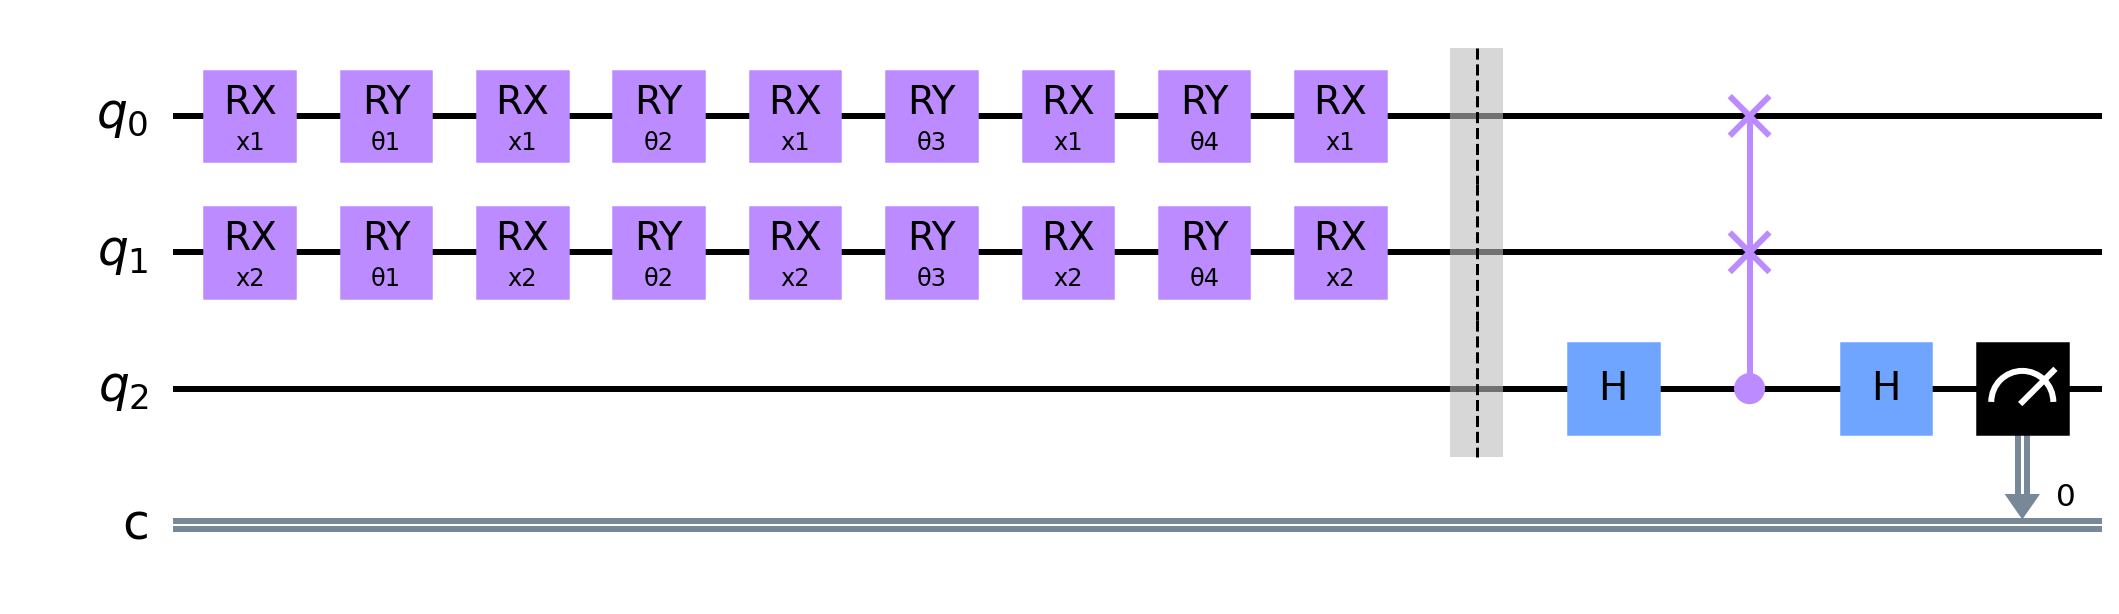

In [30]:
#c = embedding_circuit(x_train_0[0], x_train_1[1], np.random.rand(4))
thetas = [Parameter(f"θ{i}") for i in range(1, 5)]
x1 = Parameter("x1")
x2 = Parameter("x2")

qc = QuantumCircuit(3, 1)
RX1 = Gate(name="RX", num_qubits=1, params=[x1])
RX2 = Gate(name="RX", num_qubits=1, params=[x2])

qc.append(RX1, [0])
qc.append(RX2, [1])

for theta in thetas:
    qc.append(Gate(name="RY", num_qubits=1, params=[theta]),[0])
    qc.append(Gate(name="RY", num_qubits=1, params=[theta]), [1])
    
    qc.append(RX1, [0])
    qc.append(RX2, [1])

qc.barrier()
qc.h(2)
qc.cswap(2, 0, 1)
qc.h(2)
qc.measure(2, 0)

fig, ax = plt.subplots()
qc.draw("mpl", scale=3, ax=ax)
plt.savefig("full_circ.png")

In [8]:
optimizer = COBYLA(maxiter=500, tol=0.0001)

ret = optimizer.optimize(num_vars=4, objective_function=objective_function, initial_point=np.random.randn(4))
print(f"Final Weights: {ret[0]}\nFinal Cost: {ret[1]}\nNum of Obj Function Calls: {ret[2]}")

Final Weights: [ 2.20026138 -1.29185886 -2.09370559  1.2951607 ]
Final Cost: 0.07558333333333334
Num of Obj Function Calls: 46


Recall that the probability of measuring a given state $|\psi\rangle$ as $|0\rangle$ is: $p(0) = |\langle0|M|\psi\rangle|^{2}$ where $M$ is a measurement operator.

- To classify a datapoint as either belonging to class A or class B:
    - We use **reference states** from both classes (a sample of points from the training set). 
    - Calculate the probability by measuring the overlap between the state of our unknown datapoint and the reference states. 

Given the known data points, is our new data point going to be from one class or the other?

This will give us the probability of being in a class **GIVEN** the distance of the unknown point and our reference states. 

In [9]:
def get_probs(x_test, x_train0, x_train1, params):
    
    batch_size = 24
    backend = Aer.get_backend("qasm_simulator")
    num_shots = 10000
    sample0 = np.random.choice(x_train0, batch_size) 
    sample1 = np.random.choice(x_train1, batch_size)

    overlaps = []
    
    for x_1, x_2 in zip(sample0, sample1):
        qc_1 = embedding_circuit(x_test, x_1, params)
        qc_2 = embedding_circuit(x_test, x_2, params)
        
        results = []

        for qc in [qc_1, qc_2]:
            t_qc = transpile(qc, backend)
            result = backend.run(t_qc, shots=num_shots).result().get_counts(qc)   

            results.append(sum([int(count)/num_shots if state == "0" else -int(count)/num_shots for state, count in result.items()]))
        overlaps.append(results)

    probs = np.sum(np.array(overlaps), axis=0) / batch_size

    return {0: probs[0], 1: probs[1]}


/Users/ag30293/anaconda3/envs/quantum/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  


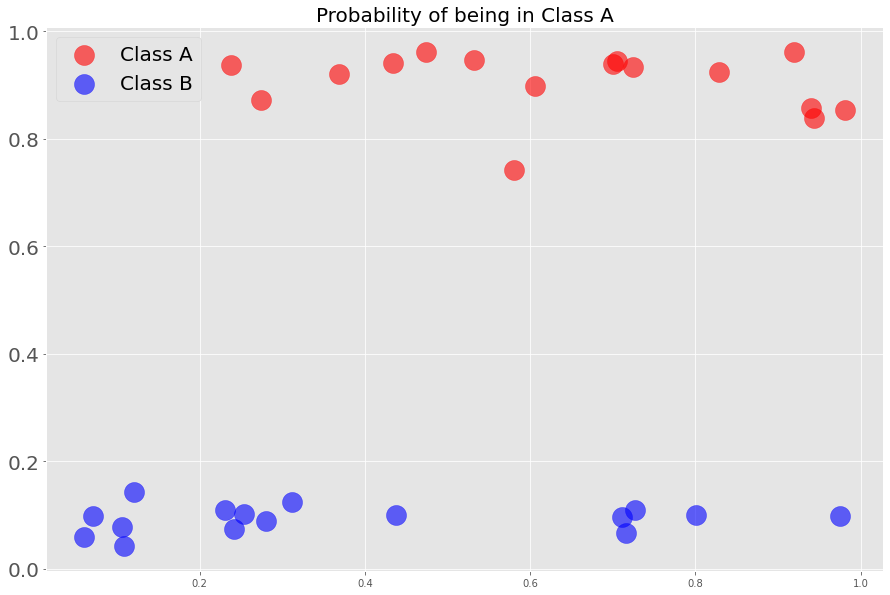

In [13]:
probs_0 = [get_probs(x, x_train_0, x_train_1, ret[0]) for x in x_test_0]
probs_1 = [get_probs(x, x_train_0, x_train_1, ret[0]) for x in x_test_1]

fig, ax = plt.subplots(figsize=(15, 10))

ax.scatter(np.random.rand(len(probs_0)), [p[0] for p in probs_0], c='r', alpha=0.6, label='Class A', s=400)
ax.scatter(np.random.rand(len(probs_1)), [p[0] for p in probs_1], c='b', alpha=0.6, label='Class B', s=400)
ax.set_yticklabels(np.round(np.arange(-0.2, 1.2, 0.2), 1), fontsize=20)
ax.set_title("Probability of being in Class A", fontsize=20)
_ = ax.legend(fontsize=20)

plt.savefig("final_probs_toy.png")

<img src="final_probs_labeled.png" width="1500" height="1000" align="center"/>

### Key Point

- These are true probability estimates, not single-point estimates and this is one of the main advantages of using quantum computing. The machines are inherently probabilistic.

- We started with a non linearly separable dataset, that we were able to classify with full probability estimates using **ONLY** three quantum bits. 

<img src="intro_files/end.png" width="2400" height="1080" align="center"/>